In [ ]:
#|default_exp explore 

# Exploring half a million molecules 

> High precision averaging of jittering masses  

## Reading an .mzML file 

First step is to read an mzML file containing (already centroided) ASAP-HRMS data. For this we will use the powerful and well documented python package [pyopenMS](https://pyopenms.readthedocs.io/en/latest/). The data can be loaded into a positive and a  negative mode dataframe as with the `read_mzml()` function. 

In [ ]:
from kendrick import read_mzml 

In [ ]:
mzml_file = '/home/frank/Work/DATA/kendrick-data/Ref0443_casein_asap01.mzML' # TODO: create download function 
df_pos, df_min = read_mzml(mzml_file)

Let's focus on the positive mode data for now. Here is what the first and last rows of the dataframe looks like. 

In [ ]:
df_pos

,RT,mz,inty
0,0.236683,125.023285,10221.680664
2,0.236683,125.059830,81648.109375
4,0.236683,125.096230,261987.234375
6,0.236683,126.055168,6278.937500
8,0.236683,126.091637,8720.198242
...,...,...,...
556990,180.309784,546.237732,35105.105469
556992,180.309784,548.254578,52922.070312
556994,180.309784,596.266724,100884.796875
556996,180.309784,610.248840,50182.472656


Inspecting the `df_pos` dataframe we find 278500 rows with three columns: 1) **RT** *retention time*, 2) **mz** *mass per electrical charge*, and 3) **inty** *number of ions*. From the first column one can see that this experiment lasted 180.3 seconds. 

As we will see, m/z values for identical molecules are slightly jittered due to limited instrumental precision. In order to determine the abundance of different molecules present in the sample, we now need to create time averaged centroided m/z values. This can be achieved by 1) first binning the data in a histogram, 2) then Gaussian smoothing the histogram and locating the peaks. These steps are implemented in the functions `histogram()` and `get_time_averaged_centroids()`. 

Next step is to explore the data in an interactive visualization. In order to plot half a million data points in a single plot we need to import a special function `interactive_plot()`. This function makes heavily use of a powerful python package [datashader](https://datashader.org/) that is designed for fast plotting huge numbers of data points. 

In [ ]:
%matplotlib widget

In [ ]:
from kendrick import histogram, get_time_averaged_centroids, interactive_plot 

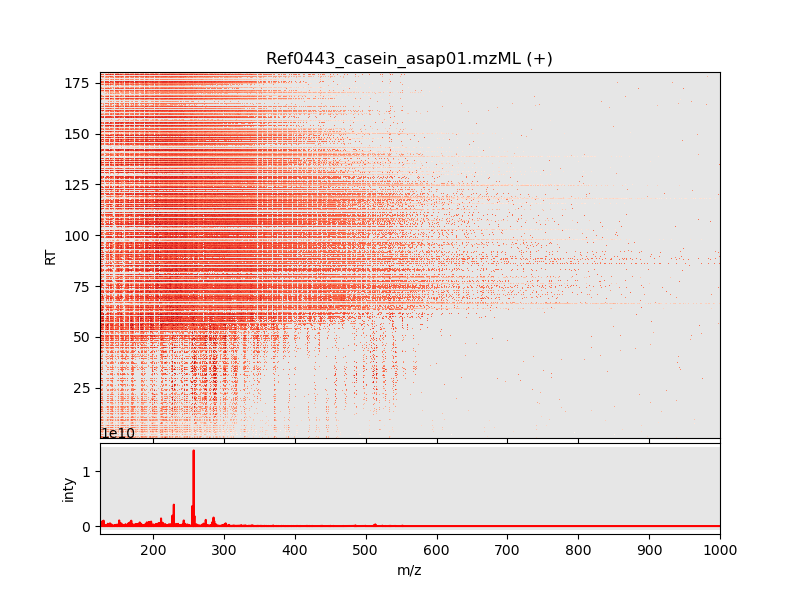

In [ ]:
mz_hist = histogram(df_pos)
mz_centroids = get_time_averaged_centroids(mz_hist)

interactive_plot(df_pos, mz_hist, mz_centroids)

![Zooming-in](images/zooming-in.gif)

In [ ]:
#|export 

import pyopenms as oms 
import dask.array as da 
import scipy.signal as ssg 
from scipy.ndimage import gaussian_filter 
import numpy as np 

import datashader as ds
import datashader.transfer_functions as tf
from datashader.mpl_ext import dsshow 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

from functools import partial  

In [ ]:
#|export  

def read_mzml(mzml_file): 
    '''Read `mzml_file`. 
    
    Returns positive and negative mode dataframes `df_pos` and `df_min`. '''

    # load example file
    exp = oms.MSExperiment()
    oms.MzMLFile().load(mzml_file, exp) 
    df_long = exp.get_df(long=True) 

    # split +/- 
    df_pos = df_long.iloc[::2] # positive?
    df_neg = df_long.iloc[1::2] # negative? 

    return df_pos, df_neg 


def histogram(df):
    '''Create intensity weighed histogram. '''

    # create dask arrays 
    x = da.from_array(df['mz'])
    y = da.from_array(df['inty']) 
    
    # make dask histograms 
    #mz_hist, bins = da.histogram(x, bins=10000000, range=[0, 1000]) # simply number of mass points in bin 
    mz_hist_w, bins = da.histogram(x, weights=y, bins=10000000, range=[0, 1000]) # weighed with intensities 
    
    # bin centers for plotting 
    bin_delta = bins[1] - bins[0]
    bin_centers = bins[0:-1] + 0.5 * bin_delta 

    mz_hist_w_xy = np.c_[bin_centers, mz_hist_w]

    return mz_hist_w_xy

def get_time_averaged_centroids(mz_hist_w_xy):
    '''Get peaks (centroids) from histogram. '''
    
    bin_centers, mz_hist_w = mz_hist_w_xy.T 
    
    # gaussian smoothing of weighed histogram 
    mz_hist_w_gauss = gaussian_filter(mz_hist_w, sigma=2)
    
    # find peaks 
    peak_idxs_w_gauss, props_dict_w = ssg.find_peaks(mz_hist_w_gauss, height=4000, distance=50) # bit ad hoc 
    peak_heights_w_gauss = props_dict_w['peak_heights'] 

    mz_x = bin_centers[peak_idxs_w_gauss] 
    mz_y = peak_heights_w_gauss 

    mz_centroids = np.c_[mz_x, mz_y]
    
    return mz_centroids  

def interactive_plot(df, mz_hist, mz_centroids): 
    '''Create interactive plot for dataframe `df`. '''

    mz_hist_x, mz_hist_y = mz_hist.T
    mz_centroids_x, mz_centroids_y = mz_centroids.T
    
    
    fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=[8, 6], gridspec_kw={'height_ratios':[4, 1]}, squeeze=True) 
    
    # number histogram 
    #ax0.plot(bin_centers, mz_hist, c='r')
    #ymin, ymax = ax0.get_ylim()
    #ax0.vlines(bin_centers[peak_idxs_w_gauss], ymin=ymin, ymax=ymax, color=[0.9, 0.9, 0.9], zorder=-10) 
    #ax0.set_ylabel('bin count')
    #ax0.set_title('Ref0443_casein_asap01.mzML (+)')
    mz_min = df['mz'].min()
    
    
    # datashader beast (the most complicated single plot command I have ever made)
    glyph = ds.Point('mz', 'RT') 
    dsshow(df, glyph, aggregator=ds.sum('inty'), ax=ax1, x_range=[100, 1000], plot_height=500, 
           plot_width=1000, aspect='auto', cmap=cm.Reds, norm='log',  
           shade_hook=partial(tf.dynspread, threshold=0.7, max_px=7, how='add')) 
    ymin, ymax = ax1.get_ylim()
    ax1.vlines(mz_centroids_x, ymin=ymin, ymax=ymax, color=[0.9, 0.9, 0.9], zorder=-10)
    ax1.set_ylabel('RT')
    ax1.set_title('Ref0443_casein_asap01.mzML (+)')
    
    # intensity weighed histogram 
    ax2.plot(mz_hist_x, mz_hist_y, color='r')
    ymin, ymax = ax2.get_ylim()
    ax2.vlines(mz_centroids_x, ymin=ymin, ymax=ymax, color=[0.9, 0.9, 0.9], zorder=-10) 
    ax2.set_ylabel('inty')
    ax2.set_xlabel('m/z')
    ax2.set_xlim([mz_min, 1000])
    
    plt.subplots_adjust(hspace=0.02)